# Quantum Circuit Simulator

Follows my implementation of the Quantum Circuit Simulator.
The assumptions made are:
- Given a gate and $n$ target_quibits, the first n-1 qubits are control qubits, while the last is the target qubit.
- Any unitary gate, which has a number of target_qubits > 1, is a controlled gate.
    - Example: {'gate': 'x', 'target': '[0,1]'} it is interpret as a X gate whose control qubit is 0 and target qubit is 1 (CX)
    - {'gate': 'x', 'target': '[0,1,2]'}, follows the same logic, thus it is a Toffoli gate

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define 2x2 identity
I = np.identity(2, dtype=np.complex)

# Define projection operator |0><0|
P0x0 = np.array([ [1,0], [0,0] ], dtype=np.complex)

# Define projection operator |1><1|
P1x1 = np.array([ [0,0], [0,1] ], dtype=np.complex)

### Utility Functions

In [3]:
def _to_binary(value : int, n_qubits : int):
    # Given a value, returns its binary representation module n_qubits. 
    bin_str_pattern = '{:0%sb}' % n_qubits
    return bin_str_pattern.format(value)[::-1] #Reversing string: first position, less significant bit

In [4]:
def normalize(d, target=1.0):
   raw = sum(d.values())
   factor = target/raw
   return {key:value*factor for key,value in d.items()}

In [5]:
def _validate_program(total_qubits, program):
    # Check if the target qubits in the program instructions are within the qubits allocated in the ground state
    qubit_list = range(total_qubits)
    for instruction in program:
        targets_qubit = instruction['target']
        for qubit in targets_qubit:
            if qubit not in qubit_list:
                raise Exception("A target qubit is not present in the circuit. qubit: ", qubit)

In [6]:
def _gate_name_to_matrix(gate_name, params=None):
    # Given a gate_name, return its matrix representation
    # Default gates: 'h', 'x', 'cx', 'ccx' and 'u3'
    if gate_name == 'h':
        return np.array([[0.70710678, 0.70710678], [0.70710678, -0.70710678]], dtype=np.complex)
    elif gate_name == 'x' or gate_name == 'cx' or gate_name == 'ccx':
        return np.array([[0,1], [1,0]], dtype=np.complex)
    elif gate_name == 'u3' and params != None:
        return [[np.cos(params['theta']/2), -np.exp(1j * params['lamb']) * np.sin(params['theta'] / 2)],
                [np.exp(1j* params['phi']) * np.sin(params['theta'] / 2), np.exp(1j * params['lamb'] + 1j * params['phi']) * np.cos(params['theta'] / 2)]]
    else:
        raise Exception("Undefined Gate", gate_name)

In [7]:
def _get_matrix_by_qubit_index(qubit_index, control_qubits, target_qubit, i, index, bin_value, gate_unitary):
    # Returns a unitary matrix according to the qubit_index:
    # - If the qubit is a control qubit, then a projector returns.
    # - Else If the qubit is a target qubit and the controls_qubit are set to 11..111, then gate_unitary returns.
    # - Else Identity matrix returns.
    if qubit_index in control_qubits:
        if bin_value[index] == '0':
            return P0x0, index+1
        else:
            return P1x1, index+1
    elif qubit_index in target_qubit and i == 2**len(control_qubits) - 1: 
       return gate_unitary, index
    else:
        return I, index

## Suggested functions

In [8]:
def get_ground_state(num_qubits):
    # return vector of size 2**num_qubits with all zeroes except first element which is 1
    if num_qubits > 0:
        gs = np.zeros(2**num_qubits, dtype=np.complex)
        gs[0] = 1
        return gs
    raise Exception("Number of qubits must be grater than 0")

In [9]:
def get_operator(total_qubits, gate_unitary, target_qubits):
    # return unitary operator of size 2**n x 2**n for given gate and target qubits

    #Splitting control qubits and target qubit
    # - Assumption: the last qubits in targets_qubit is the target_qubit while the others are controls qubits.
    target_qubit = np.array(target_qubits[-1])
    control_qubits = target_qubits[:-1]
    
    # According to the general definition of controlled-gates defined in:
    # https://github.com/quantastica/qosf-mentorship/blob/master/qosf-simulator-task-additional-info.pdf
    # Given n control_qubits, there will be 2^n combination of  projection operators.
    operand = 0
    for i in range(2**len(control_qubits)):  
        bin_value = _to_binary(i, len(control_qubits)) 
        temp, index = _get_matrix_by_qubit_index(0, control_qubits, target_qubit, i, 0, bin_value, gate_unitary)
        for qubit_index in range(1, total_qubits):
            matr, index = _get_matrix_by_qubit_index(qubit_index, control_qubits, target_qubit, i, index, bin_value, gate_unitary)
            temp = np.kron(temp, matr)
        operand = operand + temp
    return operand

In [10]:
def run_program(initial_state, program):
    # read program, and for each gate:
    #   - calculate matrix operator
    #   - multiply state with operator
    # return final state
    total_qubits = int(np.log2(len(initial_state)))
    _validate_program(total_qubits, program)
    state_vector = initial_state
    for instruction in program:
        if 'params' in instruction: #u3 rotation
            matrix = _gate_name_to_matrix(instruction['gate'], instruction['params'])
        else:  #h, c, cx, ccx
            matrix = _gate_name_to_matrix(instruction['gate'])
        operand = get_operator(total_qubits, matrix, instruction['target'])
        state_vector = np.dot(operand, state_vector)
    return state_vector

In [11]:
def measure_all(state_vector):
    # choose element from state_vector using weighted random and return it's index
    probabilities = np.array(np.square(state_vector), dtype=float) #complex to float probabilities
    indexes = range(len(state_vector))
    element_index = np.random.choice(indexes, p=probabilities)
    return _to_binary(element_index, int(np.log2(len(state_vector))))

In [12]:
def get_counts(state_vector, num_shots):
    # simply execute measure_all in a loop num_shots times
    counts = {}
    for i in range(num_shots):
        measurement = measure_all(state_vector)
        counts[measurement] = counts.get(measurement, 0) + 1
    return counts

## Main

<ipython-input-11-ea917e9cc0a7>:3: ComplexWarning: Casting complex values to real discards the imaginary part
  probabilities = np.array(np.square(state_vector), dtype=float) #complex to float probabilities


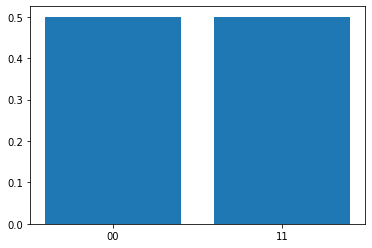

In [13]:
#Example of entanglement

my_qpu = get_ground_state(2)

my_circuit = [
    #{'gate': 'h', 'target': [0]},
    {'gate': 'u3', 'params': { 'theta': -1.5708, 'phi': 0, 'lamb': 0}, "target": [0]}, #Hadamard
    {'gate': 'x', 'target': [0,1]},
]

final_state = run_program(my_qpu, my_circuit)
counts = get_counts(final_state, 1000)

plt.bar(*zip(*normalize(counts).items()))
plt.show()